# 20152410 배형준 머신러닝 과제10

In [2]:
# library import

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# set my local working directory

import os

directory = 'C:\\Users\\golds\\Desktop\\중앙대학교\\2020-1 4학년 1학기\\머신러닝'
os.chdir(directory)

In [4]:
# load dataset

filename = './과제10/mnist.csv'
mnist = pd.read_csv(filename, header=None)
mnist.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# convert data type from pd.DataFrame to np.array

label = np.array(mnist.iloc[:, 0]).reshape(-1, 1)
data = np.array(mnist.iloc[:, 1:])

## Implement Normalization class

행 방향으로 정규화 : 한 행에서 (하나의 숫자 그림에서) 가장 작은 값이 0, 가장 큰 값이 1이 되도록 변환

In [6]:
# make class 'minmaxscaler'

class minmaxscaler:
    
    def __init__(self):
        self.min_value = 0
        self.max_value = 0
        
    def fit(self, X):
        X = np.array(X)
        self.min_value = np.min(X, axis=1)
        self.max_value = np.where(np.max(X, axis=1) == 0, 1, np.max(X, axis=1))
        # 행 별 최대 최소, 열 방향으로
        
        return self
    
    def transform(self, X):
        X = np.array(X)
        scaled = np.zeros(X.shape)
        
        for j in range(X.shape[0]):
            scaled[j, :] = (X[j, :] - self.min_value[j]) / (self.max_value[j] - self.min_value[j])
        
        return scaled

In [7]:
minmax_scaler_model = minmaxscaler()
minmax_scaler_model.fit(data)
data_scaled = minmax_scaler_model.transform(data)

## Implement Onehot encoding class

In [8]:
class onehotencoding:
    
    def __init__(self):
        self.unique = 0
    
    def fit(self, X):
        X = np.array(X)
        self.unique = np.unique(X)
        
        return self
    
    def transform(self, X):
        X = np.array(X)
        m = X.shape[0]
        n = self.unique.shape[0]
    
        empty = np.zeros((m, n))
        
        for i in range(m):
            for j in range(n):
                if X[i] == self.unique[j]:
                    empty[i, j] = 1
        
        return empty

In [9]:
onehot_model = onehotencoding()
onehot_model.fit(label)
label_onehot = onehot_model.transform(label)

## Split trainset and testset

In [10]:
train_index = 1000

train_label = label[:train_index]
test_label = label[train_index:]

label_onehot_train = label_onehot[:train_index, :]
label_onehot_test = label_onehot[train_index:, :]

data_scaled_train = data_scaled[:train_index, :]
data_scaled_test = data_scaled[train_index:, :]

## Implement Penalized Neural Network class

In [159]:
class penalized_neural_network:

    def __init__(self, learning_rate, error_bound, iteration, random_state,
                 hidden_layer, number_node, fit_intercept, alpha):
        self.learning_rate = learning_rate
        self.error_bound = error_bound
        self.iteration = iteration
        self.random_state = random_state
        self.alpha = alpha # penalized hyper parameter
        self.number_parameter = 0
        
        self.hidden_layer = hidden_layer # int
        self.number_node = number_node # list of int
        self.fit_intercept = fit_intercept # True or False
        
        self.record_train_cost = []
        self.record_test_cost = []
        self.record_train_accuracy = []
        self.record_test_accuracy = []
        
        self.coef_list = []
        self.train_predict = []
        self.test_predict = []
        self.last_gradient = []
    
    def sigmoid(self, X, coef):
        z = np.dot(X, coef)
        sigmoid_value = 1 / (1 + np.exp(-z))
        
        return sigmoid_value
    
    def cost(self, X, coef_list, onehot_label):
        delta = 10**(-8)
        m = X.shape[0]
        temp = X
        sigmoid_list = []
        
        # forward propagation
        for coef in coef_list:    
            sig = self.sigmoid(temp, coef)
            sigmoid_list.append(sig)
            
            if self.fit_intercept == True:
                temp = np.column_stack((np.ones((sig.shape[0], 1)), sig))
            else:
                temp = sig
        
        error_term = -np.mean(np.sum(onehot_label * np.log(sig + delta) + (1 - onehot_label) * np.log(1 - sig + delta), axis=1))
        
        l2_term = 0
        for coef in coef_list:
            temp = self.alpha * np.mean(coef**2) / 2
            l2_term = l2_term + temp
            
        cost_value = error_term + l2_term
        
        return cost_value, sigmoid_list
    
    def gradient(self, X, coef_list, onehot_label, sigmoid_list):
        m = X.shape[0]
        delta_list = []
        gradient_list = []
        
        add_constant_sigmoid = []
        
        for i in range(len(sigmoid_list)):
            temp = np.column_stack((np.ones((sigmoid_list[i].shape[0], 1)), sigmoid_list[i]))
            add_constant_sigmoid.append(temp)
        
        sigmoid_list.insert(0, X)
        add_constant_sigmoid.insert(0, X)
        
        # backward propagation
        for i in range(self.hidden_layer+1):
            if i == 0:
                delta_value = sigmoid_list[-1] - onehot_label
                penarlized_term = self.alpha * coef_list[-1] / self.number_parameter
                gradient_value = np.dot(add_constant_sigmoid[-2].T, delta_value) / m + penarlized_term
                
                delta_list.insert(0, delta_value)
                gradient_list.insert(0, gradient_value)
            
            else:
                delta_value = np.dot(delta_list[0], coef_list[-i][1:, :].T) * sigmoid_list[-i-1] * (1 - sigmoid_list[-i-1])
                penarlized_term = self.alpha * coef_list[-i-1] / self.number_parameter
                gradient_value = np.dot(add_constant_sigmoid[-i-2].T, delta_value) / m + penarlized_term
                
                delta_list.insert(0, delta_value)
                gradient_list.insert(0, gradient_value)
        
        return gradient_list
    
    def predict(self, sigmoid_list, predict_type='class'):
        output_layer = sigmoid_list[-1]
        
        if predict_type == 'class':
            predict_value = np.argmax(output_layer, axis=1)
        
        elif predict_type == 'response':
            predict_value = output_layer
        
        return predict_value
    
    def fit(self, X_train, Y_train, X_test, Y_test): # Y_train, Y_test는 onehotencoding이 완료된 데이터
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        X_test = np.array(X_test)
        Y_test = np.array(Y_test)
        m = X_train.shape[0]
        n = X_train.shape[1]
        q = X_test.shape[0]
        p = Y_train.shape[1]
        label_train = np.argmax(Y_train, axis=1).reshape(-1, 1) # train accuracy 계산하기 위한 label
        label_test = np.argmax(Y_test, axis=1).reshape(-1, 1) # test accuracy 계산하기 위한 label
        
        self.number_node.insert(0, n)
        self.number_node.append(p)
        coef_list = []
        
        # fit_intercept
        if self.fit_intercept == True:
            number_node_with_intercept = []
            
            X_train = np.column_stack((np.ones((m, 1)), X_train))
            X_test = np.column_stack((np.ones((q, 1)), X_test))
            
            for number in self.number_node:
                number_node_with_intercept.append(number+1)
                
        else:
            number_node_with_intercept = self.number_node
        
        # calculate number of parameters
        number_parameter = 0
        for i in range(len(number_node_with_intercept)-1):
            temp = number_node_with_intercept[i]*number_node_with_intercept[i+1]
            number_parameter = number_parameter + temp
            
        self.number_parameter = number_parameter
        
        # set initial parameters
        np.random.seed(self.random_state) # for reproducibility
        
        for layer in range(self.hidden_layer+1):
            temp_theta = np.random.randn(number_node_with_intercept[layer], self.number_node[layer+1])
            coef_list.append(temp_theta)
        
        # check model fitting progress
        import time
        start = time.time()
        
        # model fitting
        while True:
            # calculate train and test cost
            train_cost, train_sigmoid = self.cost(X_train, coef_list, Y_train)
            test_cost, test_sigmoid = self.cost(X_test, coef_list, Y_test)
            
            self.record_train_cost.append(train_cost)
            self.record_test_cost.append(test_cost)
            
            # calculate train and test accuracy
            train_predict = self.predict(train_sigmoid, predict_type='class').reshape(-1, 1)
            test_predict = self.predict(test_sigmoid, predict_type='class').reshape(-1, 1)
            
            train_accuarcy = np.mean(train_predict == label_train)
            test_accuarcy = np.mean(test_predict == label_test)
            
            self.record_train_accuracy.append(train_accuarcy)
            self.record_test_accuracy.append(test_accuarcy)
            
            # calculate gradient using back propagation and renew the parameters
            gradient_list = self.gradient(X_train, coef_list, Y_train, train_sigmoid)
            
            for i in range(len(coef_list)):
                coef_list[i] = coef_list[i] - self.learning_rate * gradient_list[i]

            # stopping rules
            length = len(self.record_train_accuracy)
            
            if length > self.iteration:
                if self.record_train_accuracy[-2] - self.record_train_accuracy[-1] < self.error_bound:
                    break
            
            # print model fitting progress
            running_time = time.time() - start
            minute = int(running_time // 60)
            second = round(running_time % 60, 1)
            
            if length % 1000 == 0:
                print('Iter : {}, Running time : {}m {}s'.format(length, minute, second), end=', ')
                print('Train accuracy : {}%, Test accuracy : {}%'.format(round(100*train_accuarcy, 4),
                                                                         round(100*test_accuarcy, 4)))
                print('Train Cost : {}, Test Cost : {}\n'.format(train_cost, test_cost))
            
            # error situation : too much iteration
            if length > 100000:
                print('반복 횟수가 너무 많습니다. Train Cost가 수렴하지 못했습니다. 학습률을 조정해보시기 바랍니다.')
                break
                
        self.coef_list = coef_list
        self.train_predict = train_predict
        self.test_predict = test_predict
        self.last_gradient = gradient_list
        
        return self

# 0. Optimization

In [170]:
model_neural_network = penalized_neural_network(error_bound=10**(-7),
                                                random_state=20152410,
                                                fit_intercept=True,
                                                iteration=10000,
                                                learning_rate=2.5,
                                                hidden_layer=1,
                                                number_node=[50],
                                                alpha=20)

In [171]:
model_neural_network.fit(X_train=data_scaled_train,
                         Y_train=label_onehot_train,
                         X_test=data_scaled_test,
                         Y_test=label_onehot_test)

Iter : 1000, Running time : 1m 3.7s, Train accuracy : 100.0%, Test accuracy : 88.6556%
Train Cost : 12.562510354921383, Test Cost : 13.173568868737211

Iter : 2000, Running time : 2m 5.5s, Train accuracy : 100.0%, Test accuracy : 88.6333%
Train Cost : 11.102504514625176, Test Cost : 11.722901397486293

Iter : 3000, Running time : 3m 14.4s, Train accuracy : 100.0%, Test accuracy : 88.5444%
Train Cost : 10.671541468820331, Test Cost : 11.298247253138546

Iter : 4000, Running time : 4m 20.0s, Train accuracy : 100.0%, Test accuracy : 88.5111%
Train Cost : 10.493615919948823, Test Cost : 11.12430710158622

Iter : 5000, Running time : 5m 33.4s, Train accuracy : 100.0%, Test accuracy : 88.4111%
Train Cost : 10.393547211049103, Test Cost : 11.026719251125382



KeyboardInterrupt: 

## Result record

##### 1번 시도 : learning_rate=1, alpha=1, hidden_layer=2, number_node=[196, 49]

Iter : 1000, Running time : 4m 54.1s, Train accuracy : 100.0%, Test accuracy : 77.0%

Train Cost : 2.1335127255917756, Test Cost : 3.6063976066367505

##### 2번 시도 : learning_rate=2, alpha=10, hidden_layer=3, number_node=[392, 196, 98]

Iter : 400, Running time : 5m 20.6s, Train accuracy : 100.0%, Test accuracy : 74.0%

Train Cost : 22.297263176823893, Test Cost : 23.861362055036665

##### 3번 시도 : learning_rate=2, alpha=5, hidden_layer=3, number_node=[200, 100, 50]

Iter : 600, Running time : 3m 44.8s, Train accuracy : 99.9%, Test accuracy : 77.0%

Train Cost : 12.708546419774065, Test Cost : 14.21191207260918

##### 4번 시도 : learning_rate=2, alpha=10, hidden_layer=4, number_node=[396, 202, 106, 58]

Iter : 1000, Running time : 13m 18.4s, Train accuracy : 99.9%, Test accuracy : 73.0%

Train Cost : 31.285935667271428, Test Cost : 33.10418290407974

##### 5번 시도 : learning_rate=1.5, alpha=5, hidden_layer=3, number_node=[400, 200, 100]

Iter : 300, Running time : 4m 6.1s, Train accuracy : 100.0%, Test accuracy : 74.0%

Train Cost : 10.85356616938031, Test Cost : 12.449866610087245

##### 6번 시도 : learning_rate=1.5, alpha=5, hidden_layer=3, number_node=[600, 400, 200]

Iter : 400, Running time : 11m 32.9s, Train accuracy : 100.0%, Test accuracy : 73.0%

Train Cost : 10.429270136925677, Test Cost : 12.248342710283715

##### 7번 시도 : learning_rate=1.5, alpha=2.5, hidden_layer=3, number_node=[400, 200, 50]

Iter : 400, Running time : 4m 33.5s, Train accuracy : 99.9%, Test accuracy : 71.0%

Train Cost : 6.187633099447817, Test Cost : 7.920751936535808

##### 8번 시도 : learning_rate=1.5, alpha=2.5, hidden_layer=2, number_node=[160, 32]

Iter : 600, Running time : 2m 5.2s, Train accuracy : 99.8%, Test accuracy : 80.0%

Train Cost : 6.1939755479369945, Test Cost : 7.422802356823845

##### 9번 시도 : learning_rate=1.5, alpha=2.5, hidden_layer=2, number_node=[128 ,28]

Iter : 600, Running time : 2m 22.1s, Train accuracy : 99.5%, Test accuracy : 78.0%

Train Cost : 6.8827057983491216, Test Cost : 8.12447464900042

##### 10번 시도 : learning_rate=1.5, alpha=2, hidden_layer=3, number_node=[384, 96, 28]

Iter : 600, Running time : 4m 23.3s, Train accuracy : 100.0%, Test accuracy : 72.0%

Train Cost : 7.0044725800452285, Test Cost : 8.720926783718689

##### 11번 시도 : learning_rate=1.5, alpha=2, hidden_layer=3, number_node=[1176, 196, 98]

Iter : 400, Running time : 9m 20.4s, Train accuracy : 100.0%, Test accuracy : 70.0%

Train Cost : 4.363638143690686, Test Cost : 6.32730190320133

##### 12번 시도 : learning_rate=1.5, alpha=10, hidden_layer=2, number_node=[400, 100]

Iter : 600, Running time : 4m 23.0s, Train accuracy : 100.0%, Test accuracy : 78.0%

Train Cost : 16.61886629014502, Test Cost : 18.140934032137267

##### 13번 시도 : learning_rate=1.5, alpha=5, hidden_layer=2, number_node=[400, 100]

Iter : 600, Running time : 4m 30.8s, Train accuracy : 100.0%, Test accuracy : 78.0%

Train Cost : 8.528022023163393, Test Cost : 10.0633521800385

##### 14번 시도 : learning_rate=1.5, alpha=2.5, hidden_layer=2, number_node=[400, 100]

Iter : 600, Running time : 4m 27.0s, Train accuracy : 100.0%, Test accuracy : 77.0%

Train Cost : 4.334591281095076, Test Cost : 5.878851322559572

##### 15번 시도 : learning_rate=1.5, alpha=0, hidden_layer=3, number_node=[484, 225, 64]

Iter : 600, Running time : 6m 33.2s, Train accuracy : 100.0%, Test accuracy : 71.0%

Train Cost : 0.03615313859976079, Test Cost : 1.8635683863114525

##### 16번 시도 : learning_rate=1, alpha=0, hidden_layer=2, number_node=[256, 36]

Iter : 600, Running time : 3m 14.8s, Train accuracy : 99.1%, Test accuracy : 75.0%

Train Cost : 0.17607257421577072, Test Cost : 1.5254835199851304

##### 17번 시도 : learning_rate=1, alpha=1, hidden_layer=2, number_node=[256, 36]

Iter : 600, Running time : 3m 29.4s, Train accuracy : 99.1%, Test accuracy : 75.0%

Train Cost : 2.2823707500277672, Test Cost : 3.6282282415151577

##### 18번 시도 : learning_rate=1, alpha=2, hidden_layer=2, number_node=[256, 36]

Iter : 600, Running time : 3m 17.1s, Train accuracy : 99.1%, Test accuracy : 75.0%

Train Cost : 4.369932325721428, Test Cost : 5.712222180149498

##### 19번 시도 : learning_rate=1, alpha=3, hidden_layer=2, number_node=[256, 36]

Iter : 800, Running time : 4m 14.4s, Train accuracy : 99.5%, Test accuracy : 76.0%

Train Cost : 6.798340131114075, Test Cost : 8.200395158691371

##### 20번 시도 : learning_rate=1.5, alpha=2.5, hidden_layer=2, number_node=[160, 32]

Iter : 800, Running time : 2m 53.6s, Train accuracy : 100.0%, Test accuracy : 80.0%

Train Cost : 6.552738037992273, Test Cost : 7.823044505831733

##### 21번 시도 : learning_rate=1.5, alpha=0, hidden_layer=2, number_node=[160, 32]

Iter : 1000, Running time : 3m 46.1s, Train accuracy : 100.0%, Test accuracy : 78.0%

Train Cost : 0.0715112705313256, Test Cost : 1.429778399634282

##### 22번 시도 : learning_rate=1.5, alpha=1, hidden_layer=2, number_node=[160, 32]

Iter : 1000, Running time : 3m 27.6s, Train accuracy : 100.0%, Test accuracy : 78.0%

Train Cost : 2.566467443423523, Test Cost : 3.9153452487398237

##### 23번 시도 : learning_rate=1.5, alpha=2, hidden_layer=2, number_node=[160, 32]

Iter : 1000, Running time : 3m 49.8s, Train accuracy : 100.0%, Test accuracy : 78.0%

Train Cost : 5.005864176104479, Test Cost : 6.344893587122391

##### 24번 시도 : learning_rate=1.5, alpha=3, hidden_layer=2, number_node=[160, 32]

Iter : 1000, Running time : 3m 23.6s, Train accuracy : 100.0%, Test accuracy : 78.0%

Train Cost : 7.390782914772613, Test Cost : 8.720559125074821

##### 25번 시도 : learning_rate=1.5, alpha=1.25, hidden_layer=2, number_node=[160, 32]

Iter : 1000, Running time : 4m 10.6s, Train accuracy : 100.0%, Test accuracy : 78.0%

Train Cost : 3.181473002369599, Test Cost : 4.527906676848368

##### 26번 시도 : learning_rate=0.5, alpha=0, hidden_layer=2, number_node=[200, 80]

Iter : 1000, Running time : 4m 53.3s, Train accuracy : 100.0%, Test accuracy : 78.0%

Train Cost : 0.08022874158914911, Test Cost : 1.4755836092193775

##### 27번 시도 : learning_rate=0.5, alpha=0, hidden_layer=2, number_node=[400, 400]

Iter : 1000, Running time : 13m 16.7s, Train accuracy : 100.0%, Test accuracy : 71.0%

Train Cost : 0.010182299164416318, Test Cost : 2.754614334559962

##### 28번 시도 : learning_rate=0.5, alpha=0, hidden_layer=2, number_node=[700, 500]

Iter : 200, Running time : 4m 43.1s, Train accuracy : 100.0%, Test accuracy : 62.0%

Train Cost : 0.02856734173059641, Test Cost : 3.728098058353736

##### 29번 시도 : learning_rate=0.5, alpha=0, hidden_layer=2, number_node=[100, 50]

Iter : 1000, Running time : 2m 33.9s, Train accuracy : 99.8%, Test accuracy : 78.0%

Train Cost : 0.13049047959551752, Test Cost : 1.3402921008796407

##### 30번 시도 : learning_rate=0.5, alpha=0, hidden_layer=2, number_node=[200, 50]

Iter : 1000, Running time : 4m 7.3s, Train accuracy : 99.9%, Test accuracy : 77.0%

Train Cost : 0.12303526995411541, Test Cost : 1.440916356027772

##### 31번 시도 : learning_rate=0.5, alpha=0, hidden_layer=1, number_node=[400]

Iter : 800, Running time : 5m 41.2s, Train accuracy : 100.0%, Test accuracy : 78.0%

Train Cost : 0.018921751233301896, Test Cost : 2.3531646319532458

##### 32번 시도 : learning_rate=0.5, alpha=0, hidden_layer=1, number_node=[200]

Iter : 400, Running time : 1m 39.0s, Train accuracy : 100.0%, Test accuracy : 76.0%

Train Cost : 0.14165330223378417, Test Cost : 1.8070378529860032

##### 33번 시도 : learning_rate=0.5, alpha=0, hidden_layer=1, number_node=[100]

Iter : 1000, Running time : 1m 54.1s, Train accuracy : 100.0%, Test accuracy : 80.0%

Train Cost : 0.1043576728310457, Test Cost : 1.4132404902044746

##### 34번 시도 : learning_rate=0.5, alpha=0, hidden_layer=1, number_node=[50]

Iter : 1000, Running time : 1m 7.8s, Train accuracy : 99.2%, Test accuracy : 81.0%

Train Cost : 0.24302959648295108, Test Cost : 1.2145995460278238

##### 35번 시도 : learning_rate=0.5, alpha=0, hidden_layer=1, number_node=[50]

Iter : 1200, Running time : 1m 19.4s, Train accuracy : 99.6%, Test accuracy : 82.0%

Train Cost : 0.1928955747190651, Test Cost : 1.2117856578006367

##### 36번 시도 : learning_rate=0.5, alpha=0, hidden_layer=1, number_node=[40]

Iter : 1200, Running time : 1m 9.6s, Train accuracy : 99.1%, Test accuracy : 80.0%

Train Cost : 0.25271683191745076, Test Cost : 1.2949999509508896

##### 37번 시도 : learning_rate=0.5, alpha=0, hidden_layer=1, number_node=[30]

Iter : 2000, Running time : 1m 35.4s, Train accuracy : 99.2%, Test accuracy : 80.0%

Train Cost : 0.1735527016436568, Test Cost : 1.318708121532921

##### 38번 시도 : learning_rate=0.5, alpha=0, hidden_layer=1, number_node=[20]

Iter : 2000, Running time : 1m 12.2s, Train accuracy : 98.7%, Test accuracy : 80.0%

Train Cost : 0.19595108857363083, Test Cost : 1.315745542282448

##### 39번 시도 : learning_rate=0.5, alpha=0, hidden_layer=1, number_node=[50]

Iter : 2000, Running time : 2m 27.2s, Train accuracy : 100.0%, Test accuracy : 83.0%

Train Cost : 0.05917299664619862, Test Cost : 1.2701572022195897

##### 40번 시도 : learning_rate=0.5, alpha=1, hidden_layer=1, number_node=[50]

Iter : 2000, Running time : 2m 4.4s, Train accuracy : 100.0%, Test accuracy : 83.0%

Train Cost : 1.664132150236614, Test Cost : 2.845823784178929

##### 41번 시도 : learning_rate=0.5, alpha=2, hidden_layer=1, number_node=[50]

Iter : 2000, Running time : 2m 29.6s, Train accuracy : 100.0%, Test accuracy : 84.0%

Train Cost : 3.11920565262161, Test Cost : 4.272405160448106

##### 42번 시도 : learning_rate=0.5, alpha=3, hidden_layer=1, number_node=[50]

Iter : 2000, Running time : 2m 28.3s, Train accuracy : 100.0%, Test accuracy : 84.0%

Train Cost : 4.437913961966033, Test Cost : 5.56350641772605

##### 43번 시도 : learning_rate=0.5, alpha=4, hidden_layer=1, number_node=[50]

Iter : 2000, Running time : 2m 3.7s, Train accuracy : 100.0%, Test accuracy : 83.856%

Train Cost : 5.632873936203264, Test Cost : 6.732340712723448

##### 44번 시도 : learning_rate=0.5, alpha=4.5, hidden_layer=1, number_node=[50]

Iter : 2000, Running time : 2m 6.0s, Train accuracy : 100.0%, Test accuracy : 83.989%

Train Cost : 6.187346454987579, Test Cost : 7.274239161839237

##### 45번 시도 : learning_rate=0.5, alpha=5, hidden_layer=1, number_node=[50]

Iter : 3000, Running time : 3m 11.6s, Train accuracy : 100.0%, Test accuracy : 85.078%

Train Cost : 6.753368042566107, Test Cost : 7.819928145173417

##### 46번 시도 : learning_rate=0.5, alpha=6, hidden_layer=1, number_node=[50]

Iter : 3000, Running time : 3m 7.9s, Train accuracy : 100.0%, Test accuracy : 85.267%

Train Cost : 7.611233458735857, Test Cost : 8.642226008475916

##### 47번 시도 : learning_rate=0.5, alpha=7, hidden_layer=1, number_node=[50]

Iter : 4000, Running time : 4m 11.9s, Train accuracy : 100.0%, Test accuracy : 86.4222%

Train Cost : 7.944474095468704, Test Cost : 8.90537051724277

##### 48번 시도 : learning_rate=1, alpha=8, hidden_layer=1, number_node=[50]

Iter : 5000, Running time : 5m 2.1s, Train accuracy : 100.0%, Test accuracy : 87.8%

Train Cost : 7.068311364499101, Test Cost : 7.8961723211166035

##### 49번 시도 : learning_rate=1, alpha=9, hidden_layer=1, number_node=[50]

Iter : 5000, Running time : 4m 57.6s, Train accuracy : 100.0%, Test accuracy : 88.0889%

Train Cost : 7.374160851933921, Test Cost : 8.170368086727093

##### 50번 시도 : learning_rate=1, alpha=10, hidden_layer=1, number_node=[50]

Iter : 7500, Running time : 7m 28.9s, Train accuracy : 100.0%, Test accuracy : 88.3%

Train Cost : 6.774252179195781, Test Cost : 7.5073671176515315

##### 51번 시도 : learning_rate=1, alpha=9, hidden_layer=1, number_node=[50]

Iter : 7500, Running time : 7m 33.8s, Train accuracy : 100.0%, Test accuracy : 88.2111%

Train Cost : 6.478820425109996, Test Cost : 7.227959912971548

##### 52번 시도 : learning_rate=1.25, alpha=10, hidden_layer=1, number_node=[50]

Iter : 7500, Running time : 7m 39.6s, Train accuracy : 100.0%, Test accuracy : 88.5778%

Train Cost : 6.373554782519803, Test Cost : 7.099683836110189

##### 53번 시도 : learning_rate=1.4, alpha=11, hidden_layer=1, number_node=[50]

Iter : 7500, Running time : 7m 31.3s, Train accuracy : 100.0%, Test accuracy : 88.5889%

Train Cost : 6.528500780852142, Test Cost : 7.251249692825701

##### 54번 시도 : learning_rate=1.5, alpha=11, hidden_layer=1, number_node=[50]

Iter : 7500, Running time : 7m 51.1s, Train accuracy : 100.0%, Test accuracy : 88.7333%

Train Cost : 6.754416635662768, Test Cost : 7.469829713351991

##### 55번 시도 : learning_rate=2, alpha=12, hidden_layer=1, number_node=[50]

Iter : 7500, Running time : 8m 0.7s, Train accuracy : 100.0%, Test accuracy : 88.7667%

Train Cost : 6.5737291681114485, Test Cost : 7.278124375670684

##### 56번 시도 : learning_rate=2, alpha=13, hidden_layer=1, number_node=[50]

Iter : 7500, Running time : 8m 16.6s, Train accuracy : 100.0%, Test accuracy : 88.7222%

Train Cost : 6.887180935293809, Test Cost : 7.583239534992739

##### 57번 시도 : learning_rate=2.5, alpha=14, hidden_layer=1, number_node=[50]

Iter : 7500, Running time : 8m 0.4s, Train accuracy : 100.0%, Test accuracy : 88.7889%

Train Cost : 7.118411385500145, Test Cost : 7.803191792402613

##### 58번 시도 : learning_rate=2.5, alpha=15, hidden_layer=1, number_node=[50]

Iter : 8000, Running time : 8m 20.0s, Train accuracy : 100.0%, Test accuracy : 88.7778%

Train Cost : 7.412873443745047, Test Cost : 8.0913181797134

##### 59번 시도 : learning_rate=2.5, alpha=16, hidden_layer=1, number_node=[50]

Iter : 8000, Running time : 9m 11.6s, Train accuracy : 100.0%, Test accuracy : 88.8%

Train Cost : 7.721327088856155, Test Cost : 8.39348457845773

##### 60번 시도 : learning_rate=2.5, alpha=20, hidden_layer=1, number_node=[50]

Iter : 8000, Running time : 9m 36.9s, Train accuracy : 100.0%, Test accuracy : 88.8222%

Train Cost : 8.884991691379412, Test Cost : 9.5381482687071

##### 61번 시도 : learning_rate=3, alpha=30, hidden_layer=1, number_node=[50]

Iter : 8000, Running time : 8m 4.4s, Train accuracy : 100.0%, Test accuracy : 88.5111%

Train Cost : 11.461993330163502, Test Cost : 12.083107895769395

##### 62번 시도 : learning_rate=3, alpha=25, hidden_layer=1, number_node=[50]

Iter : 5000, Running time : 5m 33.4s, Train accuracy : 100.0%, Test accuracy : 88.4111%

Train Cost : 10.393547211049103, Test Cost : 11.026719251125382

##### 최종 시도 : learning_rate=2.5, alpha=20, hidden_layer=1, number_node=[50]


## Source of plot of the classification example

In [121]:
number = 10
size_row = 28
size_col = 28

test_cor_index = np.where(model_neural_network.test_predict == test_label)
test_cor_index = test_cor_index[0]
test_mis_index = np.where(model_neural_network.test_predict != test_label)
test_mis_index = test_mis_index[0]

In [122]:
cor_index = test_cor_index[:number]
cor_label = test_label[cor_index]
cor_pred = model_neural_network.test_predict[cor_index]
cor_data = data_scaled_test[cor_index, :]

mis_index = test_mis_index[:number]
mis_label = test_label[mis_index]
mis_pred = model_neural_network.test_predict[mis_index]
mis_data = data_scaled_test[mis_index, :]

In [123]:
cor_data_list = []
mis_data_list = []

for a in range(number):
    cor_pixel = cor_data[a, :].reshape(size_row, size_col)
    mis_pixel = mis_data[a, :].reshape(size_row, size_col)
    
    cor_data_list.append(cor_pixel)
    mis_data_list.append(mis_pixel)

# 1. Plot the loss curve

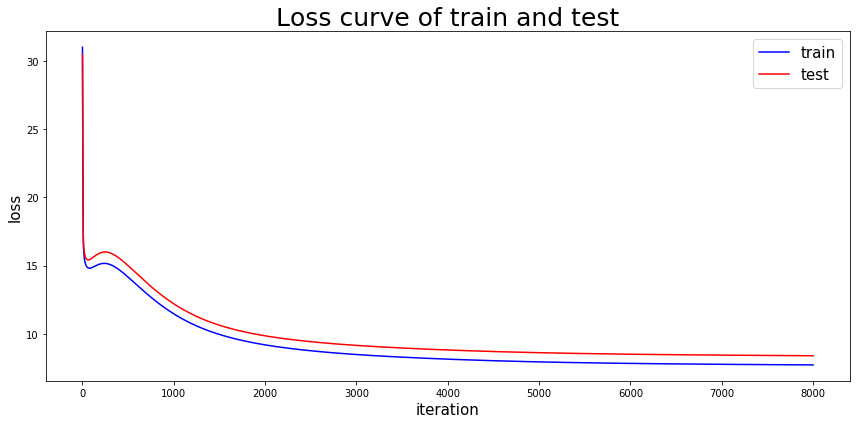

In [164]:
traincost = model_neural_network.record_train_cost
testcost = model_neural_network.record_test_cost

plt.figure(figsize=(12, 6))
plt.plot(traincost, 'b', label='train')
plt.plot(testcost, 'r', label='test')
plt.title('Loss curve of train and test', fontsize=25)
plt.xlabel('iteration', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

# 2. Plot the accuracy curve

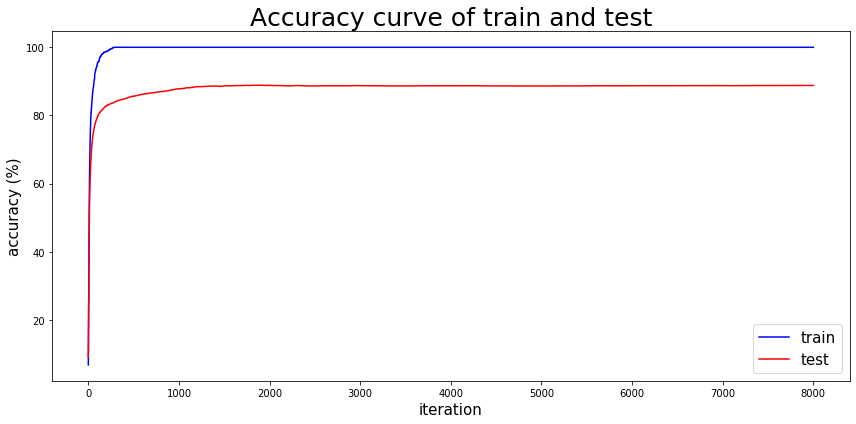

In [165]:
trainacc100 = 100*np.array(model_neural_network.record_train_accuracy)
testacc100 = 100*np.array(model_neural_network.record_test_accuracy)

plt.figure(figsize=(12, 6))
plt.plot(trainacc100, 'b', label='train')
plt.plot(testacc100, 'r', label='test')
plt.title('Accuracy curve of train and test', fontsize=25)
plt.xlabel('iteration', fontsize=15)
plt.ylabel('accuracy (%)', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

# 3. Plot the accuracy value

In [132]:
traina = round(trainacc100[-1], 5)
testa = round(testacc100[-1], 5)
trainb = traincost[-1]
testb = testcost[-1]

print('Final train accuracy : {}%, Final train loss : {}'.format(traina, trainb))
print('Final test accuracy : {}%, Final test loss : {}'.format(testa, testb))

Final train accuracy : 100.0%, Final train loss : 7.944031589793534
Final test accuracy : 86.42222%, Final test loss : 8.904890980928217


# 4. Plot the classification example

## 4-1 Plot of right-predicted classification caes

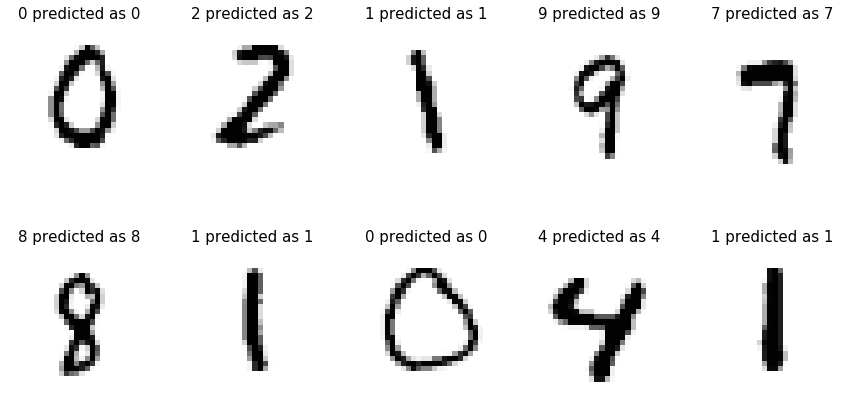

In [95]:
fig1, axes1 = plt.subplots(2, 5, figsize=(15, 7.5))
axes1 = axes1.ravel()

for p in range(number):
    axes1[p].imshow(cor_data_list[p], cmap='Greys', interpolation=None)
    axes1[p].set_title('{} predicted as {}'.format(int(cor_label[p]), int(cor_pred[p])), fontsize=15)
    axes1[p].axis('off')

## 4-2 Plot of mis-predicted classification caes

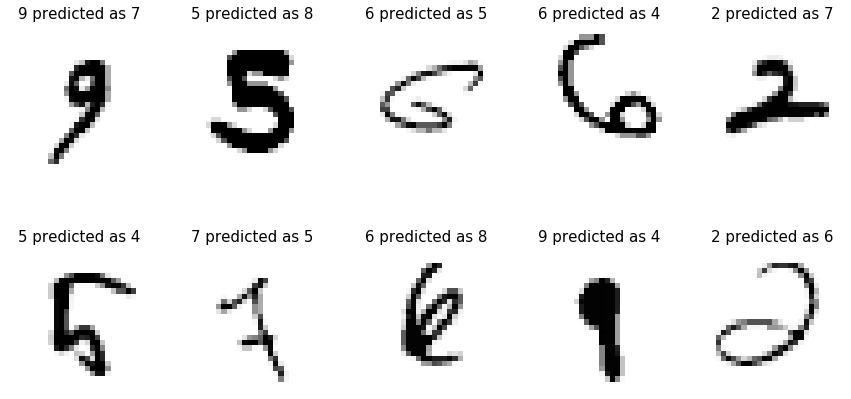

In [96]:
fig2, axes2 = plt.subplots(2, 5, figsize=(15, 7.5))
axes2 = axes2.ravel()

for p in range(number):
    axes2[p].imshow(mis_data_list[p], cmap='Greys', interpolation=None)
    axes2[p].set_title('{} predicted as {}'.format(int(mis_label[p]), int(mis_pred[p])), fontsize=15)
    axes2[p].axis('off')